- primal vs. dual
- references
    - https://domino.ai/blog/fitting-support-vector-machines-quadratic-programming
    - https://github.com/mbhaskar1/mbhaskar1.github.io/blob/master/code_examples/svm.py

In [3]:
# !pip install cvxopt

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

## original problem

$$
\begin{aligned}
& \underset{w,b}{\min}
& & \frac12\|w\|^2 \\
& \text{s.t.}
& & y_i(w^Tx_i-b)\geq 1, \quad \forall i=1,...,N
\end{aligned}
$$

- 每个约束中的等式成立的点，即为 support vector；
    - 也就是说有的数据点，都需要在 margin 上，或者在 margin 外，不允许在 margin 内；

## lagrange multipliers

$$
L(w,b,\alpha)=\frac12w^Tw-\sum_{i=1}^N\alpha_i(y_i(w^Tx_i-b)-1)
$$

## dual

$$
\max_{\alpha_i\geq 0}\left[\min_{w,b}L(w,b,\alpha)\right]
$$

- 与原问题的等价并不总是成立的；
- stationality
    - $\frac{\partial L}{\partial w}=0 \Rightarrow w=\sum_{i=1}^N\alpha_iy_ix_i$
    - $\frac{\partial L}{\partial b}=0 \Rightarrow \sum_i\alpha_iy_i=\alpha^Ty=0$
- 很重要的一个特点，对于 non support vectors（non SVs）$\Rightarrow \alpha_i=0$

因此可以转换为：


$$
\begin{split}
&\max_{\alpha_i\geq 0}\left[\sum_i\alpha_i-\frac12\sum_{ij}\alpha_i\alpha_jy_iy_jx_i^Tx_j\right]\\
&\min_{\alpha_i\geq 0}\left[\frac12\sum_{ij\in{\text{pair of sv}}}\alpha_i\alpha_jy_iy_jx_i^Tx_j-\sum_{i\in\text{sv}}\alpha_i\right]
\end{split}
$$

- 此时的约束为
    - $\alpha_i\geq 0, \forall i$
    - $\sum_i\alpha_iy_i=0$
- 优化的角度，这里其实是一个 QP（quadratic progamming）
  - 将其按照 `cvxopt.solvers.qp` 的接口形式重写为
 
$$
\begin{aligned} \min_{\alpha} \quad & (1/2) \boldsymbol{\alpha}^T H \boldsymbol{\alpha} -1^T \boldsymbol{\alpha} \\ \textrm{such that} \quad & y^T \boldsymbol{\alpha} = 0 \\ \quad & - \alpha_i \leq 0 \; \forall i \end{aligned}
$$

### why dual

- high dimensional data, if $d\geq N$ => $dN\geq N^2$
    - 比如单张图像的像素点的数量；
- $x_i^Tx_j$: kernel friendly

## cases 1

In [39]:
X = np.array([[0, 2], [0, 0], [2, 1], [3, 4], [4, 3]])
y = np.array([-1, -1, -1, 1, 1]).astype(np.double)

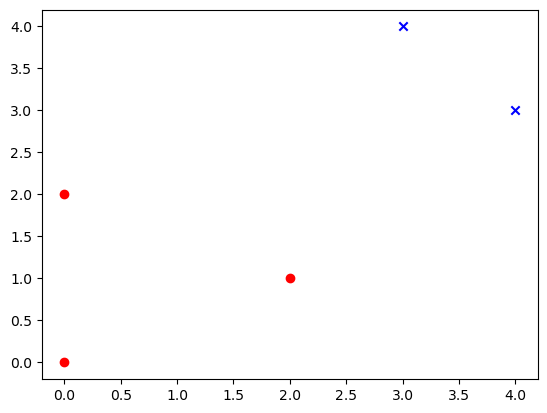

In [49]:
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='red', marker='o', label='Class -1')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', marker='x', label='Class 1')

In [40]:
N = X.shape[0]

# (1/2)*x'*P*x + q'*x
P = np.dot(y[:, np.newaxis]*X, (y[:, np.newaxis]*X).T).astype(np.double)
q = -1 * np.ones((N, 1))

# Gx <= h
G = -np.eye(N)
h = np.zeros((N, 1))

# Ax=b
A = y[np.newaxis, :]
b = np.zeros((1, 1))

In [41]:
P = matrix(P)
q = matrix(q)
G = matrix(G)
h = matrix(h)
A = matrix(A.astype('double'))
b = matrix(b)

In [42]:
sol = solvers.qp(P, q, G, h, A, b)

     pcost       dcost       gap    pres   dres
 0: -6.8470e-01 -1.3037e+00  1e+01  3e+00  2e+00
 1:  8.4198e-02 -8.1246e-01  1e+00  2e-01  9e-02
 2: -1.6351e-01 -3.4503e-01  2e-01  8e-17  4e-16
 3: -2.3651e-01 -2.5404e-01  2e-02  4e-17  4e-16
 4: -2.4950e-01 -2.5045e-01  1e-03  3e-18  2e-16
 5: -2.4994e-01 -2.5006e-01  1e-04  3e-17  5e-16
 6: -2.4999e-01 -2.5001e-01  2e-05  4e-17  2e-16
 7: -2.5000e-01 -2.5000e-01  2e-06  9e-17  4e-16
 8: -2.5000e-01 -2.5000e-01  3e-07  6e-17  4e-16
 9: -2.5000e-01 -2.5000e-01  5e-08  6e-17  5e-16
Optimal solution found.


In [46]:
lambdas = np.asarray(sol['x'], )
lambdas

array([[1.63950105e-09],
       [5.46361524e-10],
       [2.49999998e-01],
       [1.46262626e-04],
       [2.49853737e-01]])

In [51]:
w = np.dot((y * lambdas).T, X)[0]
w

array([-1.49985373, -1.00014626])

In [63]:
S = (lambdas > 1e-5).flatten()
b = np.mean(y[S] - np.dot(X[S], w.reshape(-1,1)))
b

7.499951235589701